# Gaussian Process Regression

In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import GPy 

## Objectives

+ To do regression using a GP.
+ To introduce some diagnostics for how good a probabilistic regression is.
+ To find the hyperparameters of the GP by maximizing the (marginal) likelihood.

## Readings

+ Gaussian Processes for Machine Learning, Carl Edward Rasmussen and Christopher K. I. Williams: http://www.gaussianprocess.org/gpml


## Example: Gaussian process regression in 1D with fixed hyper-parameters

Let's generate some synthetic 1D data to work with:

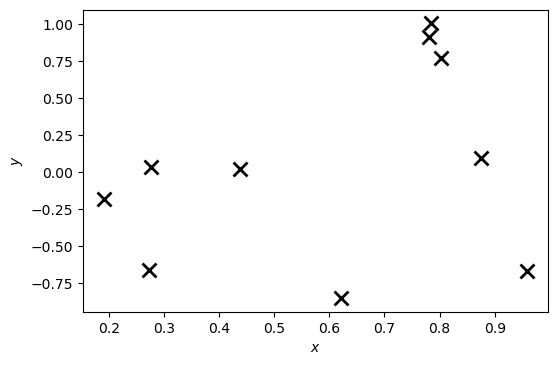

In [2]:
# Fixing the seed so that we all see the same data
np.random.seed(1234)
n = 10
# The inputs are in [0, 1]
X = np.random.rand(n, 1) # Needs to be an n x 1 vector
# The outputs are given from a function plus some noise
# The standard deviation of the noise is:
sigma = 0.4
# The true function that we will try to identify
f_true = lambda x: x*np.sin(8.0*np.pi*x)
# Some data to train on
Y = f_true(X) + sigma * np.random.randn(X.shape[0], 1)
# Let's visualize the data
fig, ax = plt.subplots(dpi=100)
ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

In [3]:
# Now, we will get started with the regression

# First, pick a kernel. Let's pick a squared exponential (RBF = Radial Basis Function)
k = GPy.kern.RBF(1) # The parameter here is the dimension of the input (here 1)
# Let's print the kernel object to see what it includes:
print(k)

  rbf.         |  value  |  constraints  |  priors
  variance     |    1.0  |      +ve      |        
  lengthscale  |    1.0  |      +ve      |        


The ``variance`` of the kernel is one. This seems reasonable.
Let's leave it like that.
The ``lengthscale`` seems to big.
Let's change it to something reasonable (based on our expectations):

In [4]:
k.lengthscale = 0.1
print(k)

  rbf.         |  value  |  constraints  |  priors
  variance     |    1.0  |      +ve      |        
  lengthscale  |    0.1  |      +ve      |        


There is a possibility to choose a mean function, but for simplicity we are going to pick a zero mean function:
$$
m(x) = 0.
$$
Now we put together the GP regression model as follows:

In [5]:
gpm = GPy.models.GPRegression(X, Y, k) # It is input, output, kernel

This model is automatically assuming that the likelihood is Gaussian (you can modify it if you wish).
Where do can you find the $\sigma^2$ parameter specifying the likelihood noise? Here it is:

In [6]:
print(gpm)


Name : GP regression
Objective : 12.824983187705946
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  rbf.variance             |    1.0  |      +ve      |        
  rbf.lengthscale          |    0.1  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        


We will talk about the meaning of all that later. For now, let's just fix the noise variance to something reasonable (actually the correct value):

In [7]:
gpm.likelihood.variance = sigma ** 2
print(gpm)


Name : GP regression
Objective : 9.164825967781379
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  rbf.variance             |                  1.0  |      +ve      |        
  rbf.lengthscale          |                  0.1  |      +ve      |        
  Gaussian_noise.variance  |  0.16000000000000003  |      +ve      |        


That's it. We have now specified the model completely.
The posterior GP is completely defined.
Where is the posterior mean $m_n(x)$ and variance $\sigma_n^2(x)$? You can get them like this:

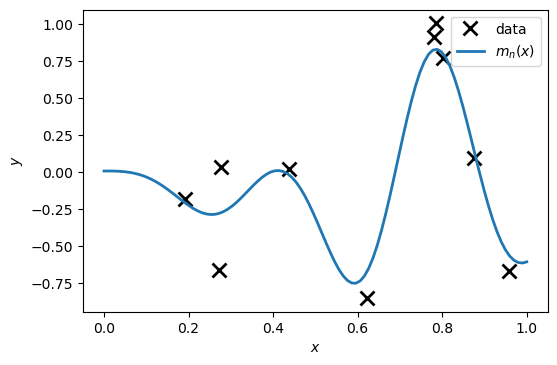

In [8]:
# First the mean on some test points
x_star = np.linspace(0, 1, 100)[:, None] # This is needed to turn the array into a column vector
m_star, v_star = gpm.predict(x_star)
# Let's plot the mean first
fig, ax = plt.subplots(dpi=100)
ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2, label='data')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.plot(x_star, m_star, lw=2, label='$m_n(x)$')
plt.legend(loc='best');

Extracting the variance is a bit more involved.
Just a tiny bit though.
This is because ``v_star`` returned by ``gpm.predict`` is not exactly $\sigma_n^2(x)$.
It is actually $\sigma_n^2(x) + \sigma^2$ and not just $\sigma_n^2(x)$.
Here, see it:

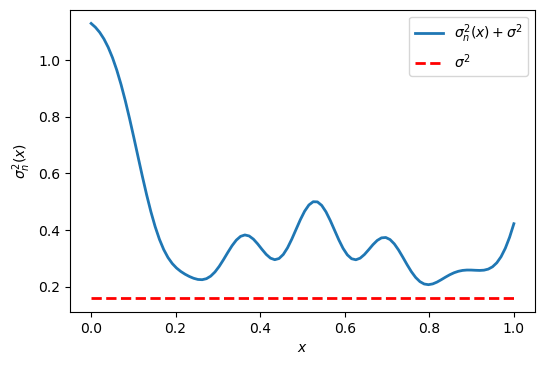

In [9]:
# Now the variance on the same test points
fig, ax = plt.subplots(dpi=100)
ax.plot(x_star, v_star, lw=2, label='$\sigma_n^2(x) + \sigma^2$')
ax.plot(x_star, gpm.likelihood.variance * np.ones(x_star.shape[0]), 'r--', lw=2, label='$\sigma^2$')
ax.set_xlabel('$x$')
ax.set_ylabel('$\sigma_n^2(x)$')
plt.legend(loc='best');

Notice that the variance is small wherever we have an observation.
It is not, however, exactly, $\sigma^2$.
It will become exactly $\sigma^2$ in the limit of many observations.

Having the posterior mean and variance, we can derive 95\% predictive intervals for $f(x^*)$ and $y^*$.
For $f(x^*)$ these are:
$$
m_n(\mathbf{x}^*)) - 2\sigma_n(\mathbf{x}^*) \le f(\mathbf{x}^*) \le m_n(\mathbf{x}^*)) + 2\sigma_n(\mathbf{x}^*).
$$
Let's plot this:

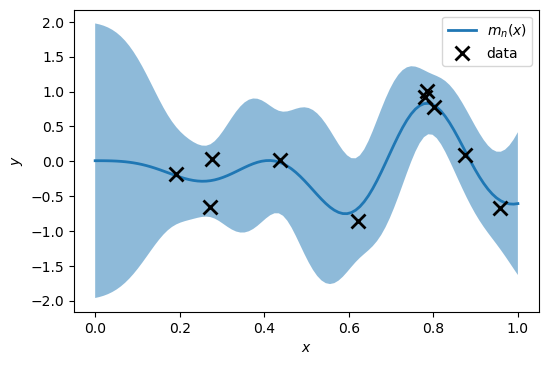

In [10]:
fig, ax = plt.subplots(dpi=100)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
f_lower = m_star - 2.0 * np.sqrt(v_star - gpm.likelihood.variance)
f_upper = m_star + 2.0 * np.sqrt(v_star - gpm.likelihood.variance)
ax.fill_between(x_star.flatten(), f_lower.flatten(), f_upper.flatten(), alpha=0.5)
ax.plot(x_star, m_star, lw=2, label='$m_n(x)$')
ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2, label='data')
plt.legend(loc='best');

Now, on the same plot, let's superimpose our predictive error bar about $y^*$.
This is:
$$
m_n(\mathbf{x}^*)) - 2\sqrt{\sigma_n^2(\mathbf{x}^*)+\sigma^2}\le f(\mathbf{x}^*) \le m_n(\mathbf{x}^*)) + 2\sqrt{\sigma_n(\mathbf{x}^*) + \sigma^2}.
$$
Let's use red color for this:

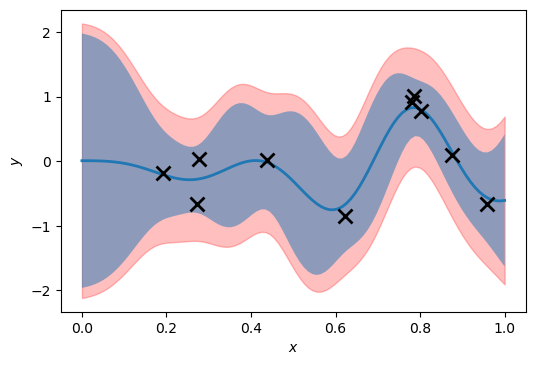

In [11]:
fig, ax = plt.subplots(dpi=100)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
f_lower = m_star - 2.0 * np.sqrt(v_star - gpm.likelihood.variance)
f_upper = m_star + 2.0 * np.sqrt(v_star - gpm.likelihood.variance)
y_lower = m_star - 2.0 * np.sqrt(v_star)
y_upper = m_star + 2.0 * np.sqrt(v_star)
ax.fill_between(x_star.flatten(), y_lower.flatten(), y_upper.flatten(), color='red', alpha=0.25, label='$y^*$ 95% pred.')
ax.fill_between(x_star.flatten(), f_lower.flatten(), f_upper.flatten(), alpha=0.5, label='$f(\mathbf{x}^*)$ 95% pred.')
ax.plot(x_star, m_star, lw=2, label='$m_n(x)$')
ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2, label='data')
#plt.legend(loc='best');

Let's also put the correct function there for comparison:

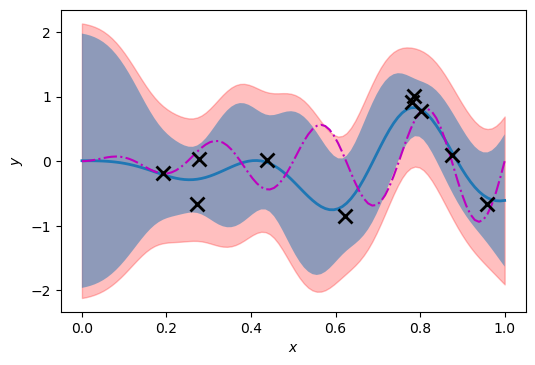

In [12]:
fig, ax = plt.subplots(dpi=100)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
f_lower = m_star - 2.0 * np.sqrt(v_star - gpm.likelihood.variance)
f_upper = m_star + 2.0 * np.sqrt(v_star - gpm.likelihood.variance)
y_lower = m_star - 2.0 * np.sqrt(v_star)
y_upper = m_star + 2.0 * np.sqrt(v_star)
ax.fill_between(x_star.flatten(), y_lower.flatten(), y_upper.flatten(), color='red', alpha=0.25, label='$y^*$ 95% pred.')
ax.fill_between(x_star.flatten(), f_lower.flatten(), f_upper.flatten(), alpha=0.5, label='$f(\mathbf{x}^*)$ 95% pred.')
ax.plot(x_star, m_star, lw=2, label='$m_n(x)$')
ax.plot(x_star, f_true(x_star), 'm-.', label='True function')
ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2, label='data');
#plt.legend(loc='best');

You see that the true function is almost entirely within the blue bounds.
It is ok that it is a little bit off, becuase these are 95% prediction intervals.
About 5% of the function can be off.

That's good.
However, we have much more information encoded in the posterior GP.
It is actually a probability measure over the space of functions.
How do we sample functions?
Well, you can't sample functions...
They are infinite objects.
But you can sample the *function values* on a bunch of test points.
As a matter of fact, the joint probability density of the function values at any collection of set points is a multivariate Gaussian.
Here it is:

In [13]:
# Here is how you take the samples
f_post_samples = gpm.posterior_samples_f(x_star, 10) # Test points, how many samples you want
# Here is the size of f_post_samples
print(f_post_samples.shape)

(100, 1, 10)


This is ``test points x number of outputs (1 here) x number of samples``.
Let's plot them along with the data and the truth:

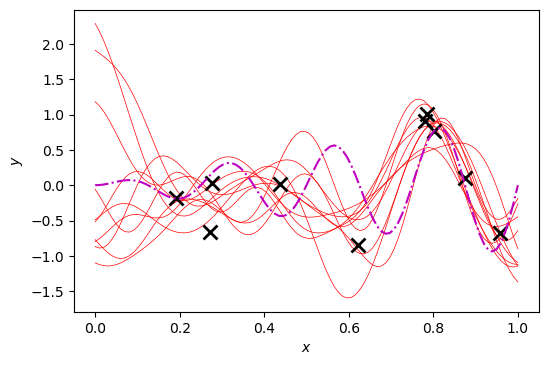

In [14]:
fig, ax = plt.subplots(dpi=100)
ax.plot(x_star, f_post_samples[:, 0, :], 'r', lw=0.5)
ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2, label='data');
ax.plot(x_star, f_true(x_star), 'm-.', label='True function')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

Ok, we see that the lengthscale we have assumed does not match the lengthscale of the true function perfectly.
But that's how it is.
In real problems, you won't know the true function anyway. 

The following interactive function regenerates the figures above allowing you to experiment with various choices of the hyperparameters.

In [15]:
def analyze_and_plot_gp_ex1(kern_variance=1.0, kern_lengthscale=0.1, like_variance=0.4):
    """
    Performs GP regression with given kernel variance, lengthcale and likelihood variance.
    """
    k = GPy.kern.RBF(1)
    #k = GPy.kern.Matern32(1)
    gp_model = GPy.models.GPRegression(X, Y, k)
    # Set the parameters
    gp_model.kern.variance = kern_variance
    gp_model.kern.lengthscale = kern_lengthscale
    gp_model.likelihood.variance = like_variance
    # Print model for sanity check
    print(gp_model)
    # Pick test points
    x_star = np.linspace(0, 1, 100)[:, None]
    # Get posterior mean and variance
    m_star, v_star = gp_model.predict(x_star)
    # Plot 1: Mean and 95% predictive interval
    fig1, ax1 = plt.subplots()
    ax1.set_xlabel('$x$')
    ax1.set_ylabel('$y$')
    f_lower = m_star - 2.0 * np.sqrt(v_star - gp_model.likelihood.variance)
    f_upper = m_star + 2.0 * np.sqrt(v_star - gp_model.likelihood.variance)
    y_lower = m_star - 2.0 * np.sqrt(v_star)
    y_upper = m_star + 2.0 * np.sqrt(v_star)
    ax1.fill_between(x_star.flatten(), y_lower.flatten(), y_upper.flatten(), color='red', alpha=0.25, label='$y^*$ 95% pred.')
    ax1.fill_between(x_star.flatten(), f_lower.flatten(), f_upper.flatten(), alpha=0.5, label='$f(\mathbf{x}^*)$ 95% pred.')
    ax1.plot(x_star, m_star, lw=2, label='$m_n(x)$')
    ax1.plot(x_star, f_true(x_star), 'm-.', label='True function')
    ax1.plot(X, Y, 'kx', markersize=10, markeredgewidth=2, label='data')
    #plt.legend(loc='best');
    
    # Plot 2: Data plus posterior samples
    fig2, ax2 = plt.subplots()
    f_post_samples = gp_model.posterior_samples_f(x_star, 10)
    ax2.plot(x_star, f_post_samples[:, 0, :], 'r', lw=0.5)
    ax2.plot(X, Y, 'kx', markersize=10, markeredgewidth=2, label='data');
    ax2.plot(x_star, f_true(x_star), 'm-.', label='True function')
    ax2.set_xlabel('$x$')
    ax2.set_ylabel('$y$')
    #plt.legend(loc='best');

### Questions

In the interactive tool above:

+ Experiment with differnet lengthscales for the kernel. You need to click on ``Run Interact`` for the code to run.
What happens to the posterior mean and the 95% predictive error bar as the lengthscale increases (decreases)?

+ Experiment with difference likelihood variances. What happens for very big variances? What happens for very small variances?

+ Experiment with different kernel variances. This the $s^2$ parameter of the squared exponential covariance function. It specifies our prior variance about the function values. What is its effect?

+ Imagine that, as it would be the case in reality, you do not know the true function. How would you pick the correct values for the hyperparameters specifying the kernel?

+ Try some other kernels. Edit the function ``analyze_and_plot_gp_ex1`` and change the line ``k = GPy.kern.RBF(1)`` to ``k = GPy.kern.Matern52(1)``. This is a kernel that is less regular than the RBF. What do you observe?
Then try ``k = GPy.kern.Matern32(1)``. Then ``k = GPy.kern.Exponential(1)``. The last one is continuous but nowhere differentiable.
How can you pick the right kernel?

## Diagnostics: How do you know if the fit is good?

To objective test the resulting model we need a *validation dataset* consisting of inputs:
$$
\mathbf{x}^v_{1:n^v} = \left(\mathbf{x}^v_1,\dots,\mathbf{x}^v_{n^v}\right),
$$
and corresponding, observed outputs:
$$
\mathbf{y}^v_{1:n^v} = \left(y^v_1,\dots,y^v_{n^v}\right).
$$
We will use this validation dataset to define some diagnostics.
Let's do it directly through the 1D example above.
First, we generate some validation data:

In [16]:
n_v = 100
X_v = np.random.rand(n_v)[:, None]
Y_v = f_true(X_v) + sigma * np.random.randn(n_v, 1)

#### Point-predictions

Point-predictions only use $m_n\left(\mathbf{x}^v_i\right)$.
Of course, when there is a lot of noise, they are not very useful.
But let's look at what we get anyway.
(In the questions section I will ask you to reduce the noise and repeat).

The simplest thing we can do is to compare $y^v_i$ to $m_n\left(\mathbf{x}^v_i\right)$.
We start with the *mean square error*:
$$
\operatorname{MSE} := \frac{1}{n^v}\sum_{i=1}^{n^v}\left[y^v_i-m_n\left(\mathbf{x}^v_i\right)\right]^2.
$$

In [17]:
m_v, v_v = gpm.predict(X_v)
mse = np.mean((Y_v - m_v) ** 2)
print('MSE = {0:1.2f}'.format(mse))

MSE = 0.41


This is not very intuitive though.
An somewhat intuitive measure is [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination) also known as $R^2$, *R squared*.
It is defined as:
$$
R^2 = 1 - \frac{\sum_{i=1}^{n^v}\left[y_i^v - m_n(\mathbf{x}_i^v)\right]^2}{\sum_{i=1}^{n^v}\left[y_i^v-\bar{y}^v\right]^2},
$$
where $\bar{y}^v$ is the mean of the observed data:
$$
\bar{y}^v = \frac{1}{n^v}\sum_{i=1}^{n^v}y_i^v.
$$
The interpretation of $R^2$, and take this with a grain of salt, is that it gives the percentage of variance of the data explained by the model.
A score of $R^2=1$, is a perfect fit.
In our data we get:

In [18]:
R2 = 1.0 - np.sum((Y_v - m_v) ** 2) / np.sum((Y_v - np.mean(Y_v)) ** 2)
print('R2 = {0:1.2f}'.format(R2))

R2 = -0.12


Finally, on point-predictions, we can simply plot the predictions vs the observations:

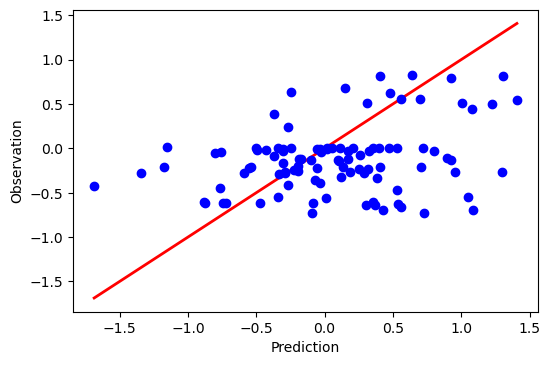

In [19]:
fig, ax = plt.subplots(dpi=100)
y_range = np.linspace(Y_v.min(), Y_v.max(), 50)
ax.plot(y_range, y_range, 'r', lw=2)
ax.plot(Y_v, m_v, 'bo')
ax.set_xlabel('Prediction')
ax.set_ylabel('Observation');

### Statistical diagnostics

Statistical diagnostics compare the predictive distribution to the distribution of the validation dataset.
The way to start, are the standarized errors defined by:
$$
e_i = \frac{y_i^v - m_n\left(\mathbf{x}^v_i\right)}{\sigma_n\left(\mathbf{x}^v_i\right)}.
$$
Now, if our model is correct, the standarized errors must be distributed as a standard normal $N(0,1)$ (why?).
There are various plots that you can do to test that.
First, the histogram of the standarized errors:

Text(0.5, 0, 'Std. error')

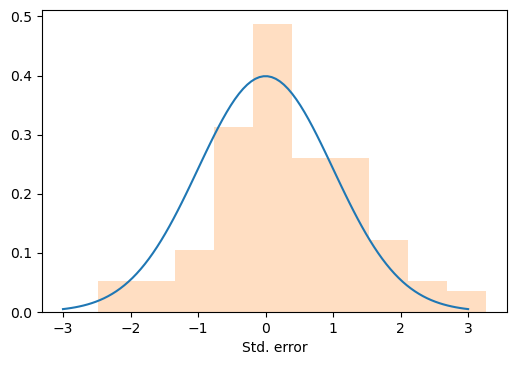

In [20]:
s_v = np.sqrt(v_v)
e = (Y_v - m_v) / s_v
fig, ax = plt.subplots(dpi=100)
zs = np.linspace(-3.0, 3.0, 100)
ax.plot(zs, st.norm.pdf(zs))
ax.hist(e, density=True, alpha=0.25)
ax.set_xlabel('Std. error')

Close, but not perfect.
Another common plot is this:

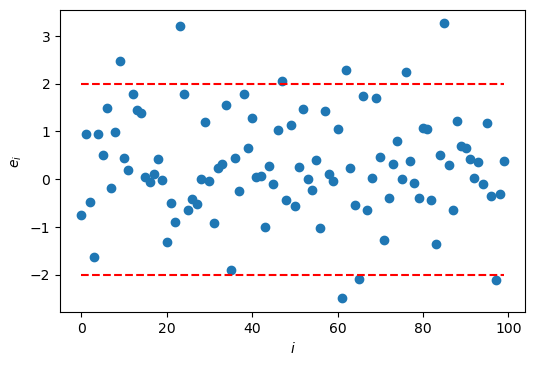

In [21]:
fig, ax = plt.subplots(dpi=100)
ax.plot(e, 'o')
ax.plot(np.arange(e.shape[0]), 2.0 * np.ones(e.shape[0]), 'r--')
ax.plot(np.arange(e.shape[0]), -2.0 * np.ones(e.shape[0]), 'r--')
ax.set_xlabel('$i$')
ax.set_ylabel('$e_i$');

Where the red lines indicate the 95% quantiles of the standard normal.
This  means that if 5\% of the errors are inside, then we are good to go.

Yet another plot yielding the same information is the q-q plot comparing the empirical quantiles of the standarized errors to what they are supposed to be, i.e., to the quantiles of $N(0,1)$:

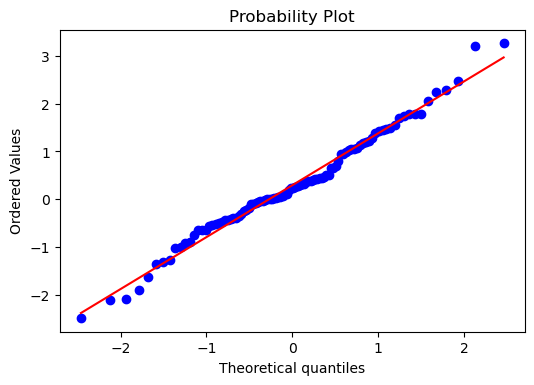

In [22]:
fig, ax = plt.subplots(dpi=100)
st.probplot(e.flatten(), dist=st.norm, plot=ax);

### Note on Gaussian process diagnostics

For a more detailed description of GP regression diagnostics, please see this [paper](https://www.jstor.org/stable/40586652).

### Questions

+ Experiment with larger number of training points $n$. Are the models becoming better according to the metrics we defined above?
+ Experiment with smaller measurement noises $\sigma$. What do you observe? Which diagnostics make sense for very small $\sigma$'s?

## Calibrating the Hyperparameters of a Gaussian Process

So, we saw how GP regression works but everything we did was conditional on knowing the hyperparameters of the covariance function, we called them $\theta$, and the likelihood variance $\sigma^2$.
But if what do we do if we are not sure about them?
We will do what we always do:

+ We summarize our state of knowledge about them by assigning prior probability density $p(\theta)$ and $p(\sigma)$.

+ We use the Bayes rule to derive our posterior state of knowledge about them:
$$
\begin{array}{ccc}
p(\theta,\sigma | \mathcal{D}) &\propto& p(\mathcal{D}|\theta,\sigma)p(\theta)p(\sigma) \\
&=& \int p(\mathbf{y}_{1:n}|\mathbf{f}_{1:n},\sigma) p(\mathbf{f}_{1:n} | \mathbf{x}_{1:n},\theta)d\mathbf{f}_{1:n} p(\theta)p(\sigma).
\end{array}
$$

+ We somehow approximate this posterior. So far, we only know of one way of approximating this posterior, and that is by a maximum a posteriori estimate.

### Maximum a Posteriori Estimate of the Hyperparameters

In the maximum a posteriori estimate (MAP) we are basically approximating the posterior with the $\delta$-function centered at its pick.
That is, we are approximating:
$$
p(\theta,\sigma|\mathcal{D}) \approx \delta(\theta-\theta^*)\delta(\sigma-\sigma^*),
$$
where $\theta^*$ and $\sigma^*$ are maximizing $\log p(\theta,\sigma|\mathcal{D})$.
It is instructive to see what $\log p(\theta,\sigma|\mathcal{D})$ looks like and see if we can assign any intuitive meaning to its terms.
It is:
$$
\begin{array}{ccc}
\log p(\theta,\sigma|\mathcal{D}) &=& \log \mathcal{N}\left(\mathbf{y}_{1:n}\middle|
\mathbf{m}(\mathbf{x}_{1:n}), \mathbf{K}(\mathbf{x}_{1:n},\mathbf{x}_{1:n}) + \sigma^2\mathbf{I}_n\right) + \log p(\theta) + \log p(\sigma) \\
&=& 
-\frac{1}{2}\left(\mathbf{y}_{1:n}-\mathbf{m}(\mathbf{x}_{1:n})\right)^T\left(\mathbf{K}(\mathbf{x}_{1:n},\mathbf{x}_{1:n}) + \sigma^2\mathbf{I}_n\right)^{-1}\left(\mathbf{y}_{1:n}-\mathbf{m}(\mathbf{x}_{1:n})\right)\\
&&-\frac{1}{2}\log |\mathbf{K}(\mathbf{x}_{1:n},\mathbf{x}_{1:n}) + \sigma^2\mathbf{I}_n|\\
&&+\log p(\theta) + \log p(\sigma)\\
&& + \text{constants}.
\end{array}
$$
The constants are terms that do not depend on $\theta$ or $\sigma$.
The first term is a familiar one.
It kind of looks like least squares (it is actually a form of least squares).
The third and forth term are familiar regularizers stemming from our prior knowledge.
The second term is a naturally occuring regularizer.

Now, back to solving the optimization problem that yields the MAP.
Of course, you need to get the deratives of $\log p(\theta,\sigma|\mathcal{D})$ and use an optimization algorithm.
Back in the stone age, we were doing this by hand.
Now you don't have to worry about it.
Automatic differentiation can work through the entire expression (including the matrix determinant).
Once you have the derivative you can use a gradient-based optimization algorithm from [scipy.optimize](https://docs.scipy.org/doc/scipy/reference/optimize.html).
``GPy`` is using by default the [L-BFGS algorithm](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-lbfgsb.html) but you could change it if you want.
These are minimization algorithms.
So, ``GPy`` is actually minimizing $-\log p(\theta,\sigma)$.
Let's see how it works through our previous example:

## Example: Gaussian process regression with fitted hyperparameters

Make sure that you still have the data from the previous example:

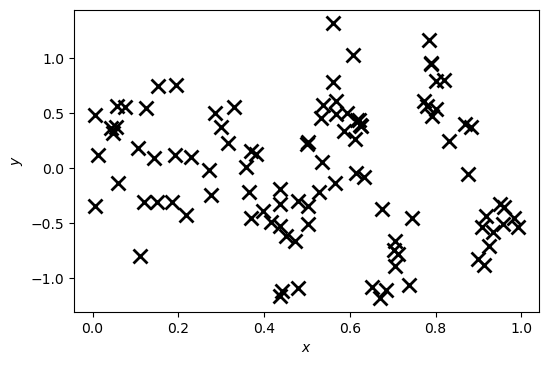

In [16]:
# Fixing the seed so that we all see the same data
np.random.seed(1234)
n = 100
# The inputs are in [0, 1]
X = np.random.rand(n, 1) # Needs to be an n x 1 vector
# The outputs are given from a function plus some noise
# The standard deviation of the noise is:
sigma = 0.4
# The true function that we will try to identify
# Some data to train on
Y = f_true(X) + sigma * np.random.randn(X.shape[0], 1)
fig, ax = plt.subplots(dpi=100)
ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

Let's pick a squared exponential kernel and make a model with Gaussian likelihood (the default choice):

In [17]:
k = GPy.kern.RBF(1) # GPy.kern.RBF(60, ARD=True)
gpm = GPy.models.GPRegression(X, Y, k)
print(gpm)


Name : GP regression
Objective : 112.15377465725129
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  rbf.variance             |    1.0  |      +ve      |        
  rbf.lengthscale          |    1.0  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        


Let's explain what all this means.
Notice that there are some default values for the hyperparameters (they are all one).
Also, notice that ``GPy`` is keeping track of how many parameters it needs to fit.
Here we have three parameters ($s,\ell$ and $\sigma$).
The second column are constraints for the parameters.
The ``+ve`` term means that the corresponding hyperparamer has to be positive.
Notice that there is nothing in the ``priors`` column.
This is because we have set no priors right now.
When this happens, ``GPy`` assumes that we assign a flat prior, i.e., here it assumes that we have assigned $p(\theta)\propto 1$ and $p(\sigma)\propto 1$.
That's not the best choice, but it should be ok for now.

Now, pay attention to the ``Objective``. This is the $-\log p(\theta,\sigma|\mathcal{D})$ for the current choice of parameters.
Let's now find the MAP:

In [18]:
gpm.optimize_restarts(messages=True) # we use multiple restarts to avoid being trapped to a local minimum
print(gpm)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0003   1.119606e+02   2.965394e+03 
    00s06  0012   8.841087e+01   2.754143e-02 
    00s07  0013   8.840648e+01   2.665347e-02 
    00s08  0017   8.840142e+01   5.799713e-05 
    00s09  0019   8.840115e+01   4.548735e-07 
    00s10  0021   8.840108e+01   7.387276e-05 
    00s12  0026   8.840107e+01   1.583095e-09 
Runtime:     00s12
Optimization status: Converged

Optimization restart 1/10, f = 88.40106594109918
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0004   9.229942e+01   7.627126e-01 
    00s06  0014   8.974560e+01   3.165539e+02 
    00s11  0027   5.834758e+01   4.820083e-09 
Runtime:     00s11
Optimization status: Converged

Optimization restart 2/10, f = 58.34757992595462
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0007   9.108641e+01   1.196918e+01 
    00s

Ok. We did find something with higher posterior value.
Let's plot the prediction:

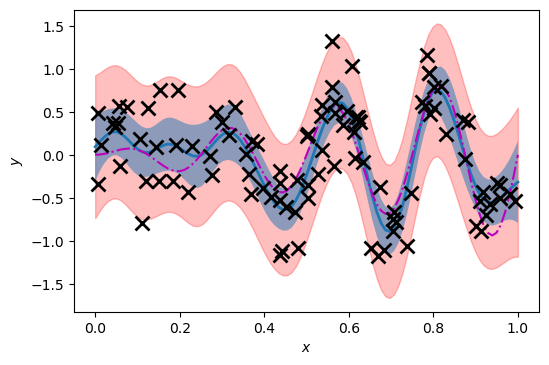

In [19]:
fig, ax = plt.subplots(dpi=100)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
m_star, v_star = gpm.predict(x_star)
f_lower = m_star - 2.0 * np.sqrt(v_star - gpm.likelihood.variance)
f_upper = m_star + 2.0 * np.sqrt(v_star - gpm.likelihood.variance)
y_lower = m_star - 2.0 * np.sqrt(v_star)
y_upper = m_star + 2.0 * np.sqrt(v_star)
ax.fill_between(x_star.flatten(), y_lower.flatten(), y_upper.flatten(), color='red', alpha=0.25, label='$y^*$ 95% pred.')
ax.fill_between(x_star.flatten(), f_lower.flatten(), f_upper.flatten(), alpha=0.5, label='$f(\mathbf{x}^*)$ 95% pred.')
ax.plot(x_star, m_star, lw=2, label='$m_n(x)$')
ax.plot(x_star, f_true(x_star), 'm-.', label='True function')
ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2, label='data');

Admitidly, this doesn't look very good.
(Of course, we can tell this only because we know the truth).
It seems that the assign lengthscale is too small.
Also, the likelihood variance seems smaller than it really is.
What do we do now?
You have two choices:
+ You encode some prior knowledge and repeat.
+ You add some more data and repeat.

Let's start with some prior knowledge and let the other item for the questions section.
Let's say that we know that the noise variance.
How do we encode this?
Here you go:

In [20]:
gpm.likelihood.variance.constrain_fixed(sigma ** 2)
print(gpm)


Name : GP regression
Objective : 59.1092502731073
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  rbf.variance             |  0.22337952833793548  |      +ve      |        
  rbf.lengthscale          |  0.05257840974082004  |      +ve      |        
  Gaussian_noise.variance  |  0.16000000000000003  |   +ve fixed   |        


Notice that it now ``GPy`` reports that the likelihood variance is fixed.
Let's repeat the optimization:

In [21]:
gpm.optimize_restarts(messages=True) # we use multiple restarts to avoid being trapped to a local minimum
print(gpm)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0000   5.910925e+01   9.830625e-09 
    00s02  0003   5.910857e+01   4.311708e-02 
    00s04  0008   5.910763e+01   8.460657e-08 
    00s05  0010   5.910763e+01   2.627278e-10 
Runtime:     00s05
Optimization status: Converged

Optimization restart 1/10, f = 59.10763348095032
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s04  0009   1.074704e+02   1.560881e-09 
    00s05  0012   1.074704e+02   7.248603e-11 
Runtime:     00s05
Optimization status: Converged

Optimization restart 2/10, f = 107.47039872979852
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0004   1.101211e+02   8.854779e+00 
    00s05  0010   7.841439e+01   1.209043e+02 
    00s11  0020   5.916392e+01   3.304814e+00 
    00s15  0026   5.910763e+01   4.190811e-13 
Runtime:     00s15
Optimization status: Converged

Op

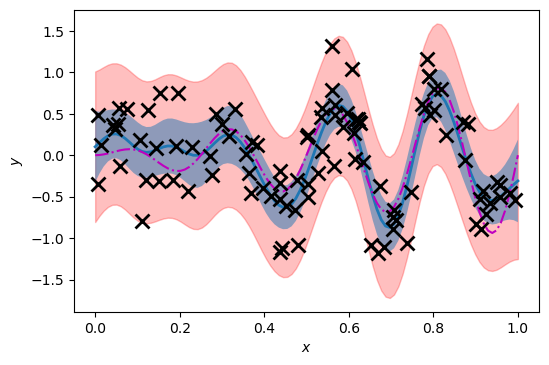

In [22]:
fig, ax = plt.subplots(dpi=100)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
m_star, v_star = gpm.predict(x_star)
f_lower = m_star - 2.0 * np.sqrt(v_star - gpm.likelihood.variance)
f_upper = m_star + 2.0 * np.sqrt(v_star - gpm.likelihood.variance)
y_lower = m_star - 2.0 * np.sqrt(v_star)
y_upper = m_star + 2.0 * np.sqrt(v_star)
ax.fill_between(x_star.flatten(), y_lower.flatten(), y_upper.flatten(), color='red', alpha=0.25, label='$y^*$ 95% pred.')
ax.fill_between(x_star.flatten(), f_lower.flatten(), f_upper.flatten(), alpha=0.5, label='$f(\mathbf{x}^*)$ 95% pred.')
ax.plot(x_star, m_star, lw=2, label='$m_n(x)$')
ax.plot(x_star, f_true(x_star), 'm-.', label='True function')
ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2, label='data');

This looks better.
But it seems that the automatically selected lengthscale is smaller than the true one.
(Of course don't really know the true lengthscale is).
Let's assign a prior probability density on the lengthscale which pushes it to be greater.
Since we are dealing with a positie parameter and we don't know much about it, let's assign an exponential prior with a rate of 2 (which will yield an expectation of 0.5):
$$
\ell \sim \operatorname{Log-N}(0.2, 1).
$$

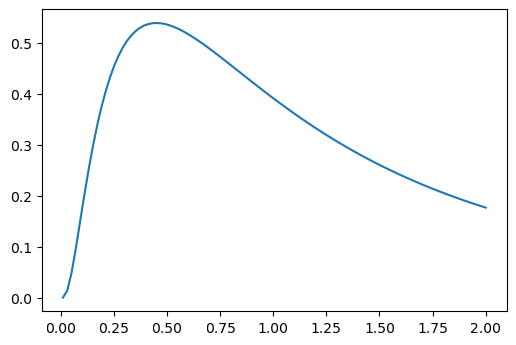

In [23]:
ell_prior = GPy.priors.LogGaussian(.2, 1.0)
# Let's visualize it to make sure it's ok
fig, ax = plt.subplots(dpi=100)
ells = np.linspace(0.01, 2.0, 100)
ax.plot(ells, ell_prior.pdf(ells))

Now here is how you can set it:

In [24]:
gpm.kern.lengthscale.set_prior(ell_prior)
print(gpm)

reconstraining parameters GP_regression.rbf.lengthscale



Name : GP regression
Objective : 64.97212792549948
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |    priors   
  rbf.variance             |  0.22164396480247509  |      +ve      |             
  rbf.lengthscale          |  0.05304542878605905  |      +ve      |  lnN(0.2, 1)
  Gaussian_noise.variance  |  0.16000000000000003  |   +ve fixed   |             


In [25]:
gpm.optimize_restarts(messages=True)
print(gpm)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s03  0005   6.478047e+01   4.083999e-01 
    00s06  0011   6.471110e+01   4.213423e-09 
Runtime:     00s06
Optimization status: Converged

Optimization restart 1/10, f = 64.71110083422847
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0004   1.163585e+02   5.050734e-01 
    00s05  0013   1.088515e+02   2.588084e-06 
    00s10  0023   1.088501e+02   4.927827e-11 
    00s10  0024   1.088501e+02   4.927827e-11 
Runtime:     00s10
Optimization status: Converged

Optimization restart 2/10, f = 108.85011592241122
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s04  0009   1.148605e+02   3.079422e+03 
    00s07  0017   6.446677e+01   1.005203e+01 
    00s10  0024   6.471110e+01   1.757047e-11 
Runtime:     00s10
Optimization status: Converged

Optimization restart 3/10, f = 64.71110083411659


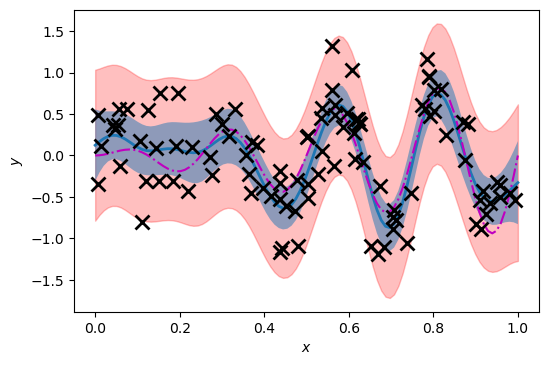

In [26]:
fig, ax = plt.subplots(dpi=100)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
m_star, v_star = gpm.predict(x_star)
f_lower = m_star - 2.0 * np.sqrt(v_star - gpm.likelihood.variance)
f_upper = m_star + 2.0 * np.sqrt(v_star - gpm.likelihood.variance)
y_lower = m_star - 2.0 * np.sqrt(v_star)
y_upper = m_star + 2.0 * np.sqrt(v_star)
ax.fill_between(x_star.flatten(), y_lower.flatten(), y_upper.flatten(), color='red', alpha=0.25, label='$y^*$ 95% pred.')
ax.fill_between(x_star.flatten(), f_lower.flatten(), f_upper.flatten(), alpha=0.5, label='$f(\mathbf{x}^*)$ 95% pred.')
ax.plot(x_star, m_star, lw=2, label='$m_n(x)$')
ax.plot(x_star, f_true(x_star), 'm-.', label='True function')
ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2, label='data');

That's better, but not perfect.
But remember: You don't know what the truth is...

## Questions

Let's investigate what happens to the previous examples as you increase the number of observations.

+ Rerun everything gradually increasing the number of samples from $n=10$ to $n=100$.
Notice that as the number of samples increases it doesn't really matter what your prior knowledge is.
As a matter of fact, for the largest number of samples you try, pick a very wrong prior probability for $\ell$.
See what happens.

+ Rerun everything with $\sigma=0.01$ (small noise) and gradually increasing the number of samples from $n=10$ to $n=100$.
For small noise, the model is trying to interpolate.
Is it capable of figuring out that the noise is small when the number of observations is limited? When does the method realize the noise is indeed small?